# Energy A.I. Hackathon 2026 Workflow - Diesel Warriors

#### Authors: Akhil Kotturi, Jayant Bhaskaruni, Arav Sawhney, Keshav Partha, Aahan Shah,  CNS (Computer Science), Cockrell SOE (PGE), CNS (SDS)
#### The University of Texas at Austin, Austin, Texas, USA
___

### Executive Summary

Our Problem is accurately predicting 3-year cumulative oil production for pre-production wells. To address the problem, our team built a geology-informed machine learning pipeline combining engineered subsurface features with an ensemble of XGBoost, Ridge, and neural network models. Through this experience, our team learned a lot about testing different models and working together of AI/ML projects. Moving forward, we will plan more and stay more structured.

___

### Workflow Goal

Our goal is to develop a robust, generalizable pipeline to predict cumulative 3-year oil production for unseen wells by blending physics-driven geological insight with machine learning and uncertainty modeling.
___

### Workflow Steps

1. Load & Check Data - Import well logs and production history and verify data quality.

2. Aggregate Well Logs - Summarize depth-based logs into per-well statistics.

3. Create Key Features - Engineer geological indicators (e.g., flow capacity), spatial context, and nearby well influence.

4. Prepare Training Data - Compute 3-year cumulative production, handle missing values, and normalize features.

5. Train Models - Train three models (XGBoost, Ridge, Neural Network) to learn production patterns.

6. Build Ensemble - Combine model predictions using performance-based weighting.

7. Apply Geology Constraint - Incorporate a physics-based geology model and blend it with the ensemble.

8. Calibrate Predictions - Adjust predictions using held-out wells to improve generalization.

9. Estimate Uncertainty - Generate multiple realizations using dropout and bootstrapping.

10. Generate Final Output - Produce point predictions and uncertainty bounds for all pre-production wells

$\ldots$


### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.pipeline import Pipeline
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from scipy.spatial.distance import cdist

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
# print("Device:", device)

### Load Data

The following workflow applies the .csv file '300well_MV.csv', a synthetic dataset calculated with geostatistical cosimulation by Wayne Gretzky, The Edmonton Oilers Hockey Team. The dataset is publically available [here](http://www.hasthelargehadroncolliderdestroyedtheworldyet.com/)  

We will work with the following features:

* **porosity** - fraction of rock void in units of percentage
* **permeability** - ability of a fluid to flow through the rock in mil;iDarcy
* **acoustic impedence** - product of sonic velocity and rock density in unitsof $kg/m^2s*10^3$

In [4]:
wl_prod = pd.read_csv("Well_log_data_production_wells.csv")
wl_pre  = pd.read_csv("Well_log_data_preproduction_wells.csv")
ph      = pd.read_csv("Production_history_production_wells.csv")

ph["Date"] = pd.to_datetime(ph["Date"])

# Aggregate well logs

Keep Well_ID as a column for safe merges




In [5]:
def aggregate_well_logs(df):
    stats = df.groupby("Well_ID").agg(["mean", "std", "min", "max"])
    stats.columns = ["_".join(c) for c in stats.columns]
    xy = df.groupby("Well_ID")[["X","Y"]].first()
    out = stats.join(xy).reset_index()  # <-- keep Well_ID as a normal column
    return out

wl_prod_agg = aggregate_well_logs(wl_prod)
wl_pre_agg  = aggregate_well_logs(wl_pre)

# Build 3-year cumulative oil target




In [6]:
def get_3yr_cumulative_oil(ph_df):
    rows = []
    oil_col = "Cumulative Oil Production, BBL"
    for wid in ph_df["Well_ID"].unique():
        w = ph_df[ph_df["Well_ID"] == wid].sort_values("Date")
        if len(w) >= 37:
            val = w.iloc[36][oil_col] - w.iloc[0][oil_col]
        else:
            val = w.iloc[-1][oil_col] - w.iloc[0][oil_col]
        rows.append({"Well_ID": wid, "CumOil_3yr": float(val)})
    return pd.DataFrame(rows)

targets = get_3yr_cumulative_oil(ph)


# Neighbor Features

### Produces:
###### - nn_idw_k3, nn_idw_k8, nn_idw_k15 (inverse-distance weighted neighbor production)
###### - dist_nn1 (distance to nearest neighbor used)




In [7]:
def add_nn_features(agg_df, prod_df, ks=(3, 8, 15)):
    agg_df = agg_df.copy()

    xy_q = agg_df[['X','Y']].values
    xy_p = prod_df[['X','Y']].values
    y_p  = prod_df['CumOil_3yr'].values.astype(float)

    id_q = agg_df['Well_ID'].values
    id_p = prod_df['Well_ID'].values

    d = cdist(xy_q, xy_p)
    # Exclude self-neighbor to prevent target leakage
    same = (id_q[:, None] == id_p[None, :])
    d[same] = np.inf

    # Sorted neighbor indices for each query
    idx_sorted = np.argsort(d, axis=1)

    # Distance to nearest neighbor (diagnostic + feature)
    nn1_idx = idx_sorted[:, 0]
    agg_df["dist_nn1"] = d[np.arange(len(agg_df)), nn1_idx]

    # Multi-k IDW features
    for k in ks:
        kk = min(k, len(prod_df))
        idx_k = idx_sorted[:, :kk]
        nn_vals = []
        for i in range(len(agg_df)):
            di = d[i, idx_k[i]] + 1e-6
            w = 1.0 / di
            nn_vals.append(np.average(y_p[idx_k[i]], weights=w))
        agg_df[f"nn_idw_k{k}"] = nn_vals

    return agg_df

# Train/Validation split BEFORE preprocessing




In [8]:
base_df = wl_prod_agg.merge(targets, on="Well_ID")

train_ids, val_ids = train_test_split(
    base_df["Well_ID"], test_size=0.2, random_state=RANDOM_SEED
)

train_df = base_df[base_df["Well_ID"].isin(train_ids)].copy()
val_df   = base_df[base_df["Well_ID"].isin(val_ids)].copy()

# Leakage-safe NN features: neighbors from TRAIN ONLY
prod_train = train_df[["Well_ID","X","Y","CumOil_3yr"]]
train_df = add_nn_features(train_df, prod_train, ks=(3,8,15))
val_df   = add_nn_features(val_df,   prod_train, ks=(3,8,15))

# Features




In [9]:
nn_cols = ["dist_nn1", "nn_idw_k3", "nn_idw_k8", "nn_idw_k15"]
feature_cols = [c for c in wl_prod_agg.columns if c != "Well_ID"] + nn_cols

X_train_raw = train_df[feature_cols].values
X_val_raw   = val_df[feature_cols].values

y_train_bbl = train_df["CumOil_3yr"].values
y_val_bbl   = val_df["CumOil_3yr"].values

# Train in log space; evaluate in BBL space (hackathon scoring uses MSE in BBL space)
y_train = np.log1p(y_train_bbl)
y_val   = np.log1p(y_val_bbl)

# Preprocessing pipelines
##### - Ridge benefits from scaling + model-based feature selection (tree importance)
##### - XGBoost does not need scaling and often performs better without aggressive feature selection





In [10]:
def make_preprocess_ridge(max_keep):
    selector_model = xgb.XGBRegressor(
        n_estimators=600, max_depth=5, learning_rate=0.05,
        subsample=0.85, colsample_bytree=0.85,
        reg_lambda=2.0, reg_alpha=0.0, gamma=0.0,
        random_state=RANDOM_SEED, objective="reg:squarederror"
    )
    return Pipeline([
        ("imputer", IterativeImputer(random_state=RANDOM_SEED, max_iter=25)),
        ("scaler", StandardScaler()),
        ("selector", SelectFromModel(selector_model, threshold="mean", max_features=max_keep))
    ])

def make_preprocess_xgb():
    return Pipeline([
        ("imputer", IterativeImputer(random_state=RANDOM_SEED, max_iter=25))
    ])

# 1) Fit imputer+scaler FIRST to determine how many features exist (train only)
pre_no_select = Pipeline([
    ("imputer", IterativeImputer(random_state=RANDOM_SEED, max_iter=25)),
    ("scaler", StandardScaler())
])

X_train_tmp = pre_no_select.fit_transform(X_train_raw, y_train)
n_feat = X_train_tmp.shape[1]
safe_max = min(120, n_feat)   # never exceed available features

# 2) Build preprocessors with safe max_features
preprocess_ridge = make_preprocess_ridge(max_keep=safe_max)
preprocess_xgb   = make_preprocess_xgb()

# Fit preprocessors on TRAIN only
X_train_ridge = preprocess_ridge.fit_transform(X_train_raw, y_train)
X_val_ridge   = preprocess_ridge.transform(X_val_raw)

X_train_xgb = preprocess_xgb.fit_transform(X_train_raw, y_train)
X_val_xgb   = preprocess_xgb.transform(X_val_raw)

print("Ridge preprocess selected features:", X_train_ridge.shape[1], "out of", n_feat)

Ridge preprocess selected features: 16 out of 90


# Models + training-set CV for stable ensemble weights




In [11]:
from sklearn.model_selection import KFold

def make_point_models():
    ridge_m = Ridge(alpha=20.0)
    xgb_m = xgb.XGBRegressor(
        n_estimators=3500,
        learning_rate=0.02,
        max_depth=6,
        min_child_weight=5,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=2.0,
        reg_alpha=0.0,
        gamma=0.0,
        random_state=RANDOM_SEED,
        objective="reg:squarederror"
    )
    return ridge_m, xgb_m

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

mse_ridge_folds = []
mse_xgb_folds = []

train_wells_base = train_df.reset_index(drop=True)

for fold, (tr_idx, va_idx) in enumerate(kf.split(train_wells_base)):
    tr_base = train_wells_base.iloc[tr_idx].copy()
    va_base = train_wells_base.iloc[va_idx].copy()

    prod_fold = tr_base[["Well_ID","X","Y","CumOil_3yr"]]
    tr = add_nn_features(tr_base, prod_fold, ks=(3,8,15))
    va = add_nn_features(va_base, prod_fold, ks=(3,8,15))

    X_tr_raw = tr[feature_cols].values
    X_va_raw = va[feature_cols].values

    y_tr_bbl = tr["CumOil_3yr"].values
    y_va_bbl = va["CumOil_3yr"].values

    y_tr = np.log1p(y_tr_bbl)

    # Fit preprocessors on fold-train only
    # Fit preprocessors on fold-train only (dynamic max_features so it never errors)

    # --- Ridge: imputer+scaler first to compute available feature count ---
    pre_no_select = Pipeline([
        ("imputer", IterativeImputer(random_state=RANDOM_SEED, max_iter=25)),
        ("scaler", StandardScaler())
    ])

    X_tr_tmp = pre_no_select.fit_transform(X_tr_raw, y_tr)
    n_feat = X_tr_tmp.shape[1]
    safe_max = min(120, n_feat)  # never exceeds available features

    selector_model = xgb.XGBRegressor(
        n_estimators=600, max_depth=5, learning_rate=0.05,
        subsample=0.85, colsample_bytree=0.85,
        reg_lambda=2.0, reg_alpha=0.0, gamma=0.0,
        random_state=RANDOM_SEED, objective="reg:squarederror"
    )

    pre_r = Pipeline([
        ("imputer", IterativeImputer(random_state=RANDOM_SEED, max_iter=25)),
        ("scaler", StandardScaler()),
        ("selector", SelectFromModel(selector_model, threshold="mean", max_features=safe_max))
    ])

    # Now transform train/val
    X_tr_r = pre_r.fit_transform(X_tr_raw, y_tr)
    X_va_r = pre_r.transform(X_va_raw)

    # --- XGB: imputer only ---
    pre_x = Pipeline([
        ("imputer", IterativeImputer(random_state=RANDOM_SEED, max_iter=25))
    ])
    X_tr_x = pre_x.fit_transform(X_tr_raw, y_tr)
    X_va_x = pre_x.transform(X_va_raw)

    ridge_f, xgb_f = make_point_models()
    ridge_f.fit(X_tr_r, y_tr)
    xgb_f.fit(X_tr_x, y_tr)

    pred_r_bbl = np.expm1(ridge_f.predict(X_va_r))
    pred_x_bbl = np.expm1(xgb_f.predict(X_va_x))

    mse_ridge = mean_squared_error(y_va_bbl, pred_r_bbl)
    mse_xgb   = mean_squared_error(y_va_bbl, pred_x_bbl)

    mse_ridge_folds.append(mse_ridge)
    mse_xgb_folds.append(mse_xgb)

    print(f"Fold {fold+1}: MSE Ridge={mse_ridge:,.0f}  MSE XGB={mse_xgb:,.0f}")

mse_ridge_cv = float(np.mean(mse_ridge_folds))
mse_xgb_cv   = float(np.mean(mse_xgb_folds))

inv = np.array([1.0/mse_xgb_cv, 1.0/mse_ridge_cv], dtype=float)
weights = inv / inv.sum()   # [w_xgb, w_ridge]

print("\nCV mean MSE (train only):")
print(f"  Ridge: {mse_ridge_cv:,.0f}")
print(f"  XGB  : {mse_xgb_cv:,.0f}")
print("\nStable ensemble weights (inverse MSE):")
print("  weights = [w_xgb, w_ridge] =", weights.tolist())

# Fit final point models on TRAIN split (for holdout validation)
ridge, xgb_model = make_point_models()
ridge.fit(X_train_ridge, y_train)
xgb_model.fit(X_train_xgb, y_train, eval_set=[(X_val_xgb, y_val)], verbose=False)

Fold 1: MSE Ridge=15,649,114,711,885  MSE XGB=29,854,751,488,068
Fold 2: MSE Ridge=13,976,034,915,455  MSE XGB=23,633,161,835,299
Fold 3: MSE Ridge=53,564,917,326,676  MSE XGB=77,702,295,174,483
Fold 4: MSE Ridge=31,099,068,886,915  MSE XGB=26,982,209,323,362
Fold 5: MSE Ridge=12,424,764,120,197  MSE XGB=21,913,142,297,891

CV mean MSE (train only):
  Ridge: 25,342,779,992,225
  XGB  : 36,017,112,023,820

Stable ensemble weights (inverse MSE):
  weights = [w_xgb, w_ridge] = [0.41301865370946467, 0.5869813462905354]


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=3500,
             n_jobs=None, num_parallel_tree=None, ...)

# Validation Evaluation





Holdout validation (BBL space) — primary metric: MSE
Ridge     MSE=63,125,084,202,272   RMSE=7,945,130   R²=0.7566
XGB       MSE=30,985,090,931,950   RMSE=5,566,425   R²=0.8805
Ensemble  MSE=45,413,187,335,394   RMSE=6,738,931   R²=0.8249


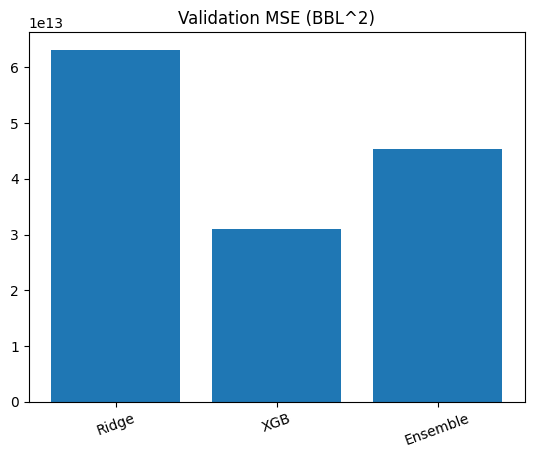

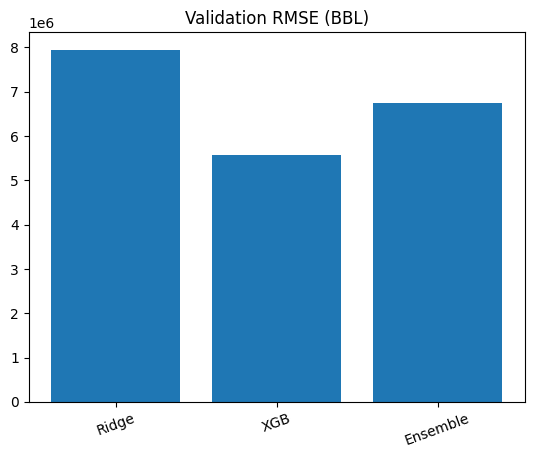

In [12]:
pred_ridge_bbl = np.expm1(ridge.predict(X_val_ridge))
pred_xgb_bbl   = np.expm1(xgb_model.predict(X_val_xgb))

# Ensemble using stable inverse-MSE weights from training-set CV
pred_ens_bbl = weights[0]*pred_xgb_bbl + weights[1]*pred_ridge_bbl

preds = {
    "Ridge": pred_ridge_bbl,
    "XGB": pred_xgb_bbl,
    "Ensemble": pred_ens_bbl
}

val_mse = {k: mean_squared_error(y_val_bbl, v) for k, v in preds.items()}
val_rmse = {k: np.sqrt(v) for k, v in val_mse.items()}
val_r2 = {k: r2_score(y_val_bbl, v) for k, v in preds.items()}  # secondary diagnostic

print("\nHoldout validation (BBL space) — primary metric: MSE")
for k in preds:
    print(f"{k:8s}  MSE={val_mse[k]:,.0f}   RMSE={val_rmse[k]:,.0f}   R²={val_r2[k]:.4f}")

plt.figure()
plt.bar(list(val_mse.keys()), list(val_mse.values()))
plt.title("Validation MSE (BBL^2)")
plt.xticks(rotation=20)
plt.show()

plt.figure()
plt.bar(list(val_rmse.keys()), list(val_rmse.values()))
plt.title("Validation RMSE (BBL)")
plt.xticks(rotation=20)
plt.show()


# Quantile regression models
(P10, P50, P90) — train on ALL labeled wells




In [13]:
# Build full labeled dataset (all production wells)
full_df = wl_prod_agg.merge(targets, on="Well_ID", how="inner").copy()

# Add NN features using all labeled wells (exclude self inside function)
prod_full = full_df[["Well_ID","X","Y","CumOil_3yr"]]
full_df = add_nn_features(full_df, prod_full, ks=(3,8,15))

# Preproduction: NN features using all labeled wells (real inference scenario)
wl_pre_nn = add_nn_features(wl_pre_agg.copy(), prod_full, ks=(3,8,15))

# Features / targets
X_full_raw = full_df[feature_cols].values
y_full_bbl = full_df["CumOil_3yr"].values
y_full = np.log1p(y_full_bbl)

X_pre_raw = wl_pre_nn[feature_cols].values

# Fit preprocessors on ALL labeled data for final models
# (compute safe max_features first so selector doesn't error)
pre_no_select_full = Pipeline([
    ("imputer", IterativeImputer(random_state=RANDOM_SEED, max_iter=25)),
    ("scaler", StandardScaler())
])
X_full_tmp = pre_no_select_full.fit_transform(X_full_raw, y_full)
safe_max_full = min(120, X_full_tmp.shape[1])

preprocess_full_ridge = make_preprocess_ridge(max_keep=safe_max_full)
preprocess_full_xgb   = make_preprocess_xgb()

X_full_ridge = preprocess_full_ridge.fit_transform(X_full_raw, y_full)
X_pre_ridge  = preprocess_full_ridge.transform(X_pre_raw)

X_full_xgb = preprocess_full_xgb.fit_transform(X_full_raw, y_full)
X_pre_xgb  = preprocess_full_xgb.transform(X_pre_raw)

print("Full-data Ridge selected features:", X_full_ridge.shape[1], "out of", X_full_tmp.shape[1])

# Fit final point models on ALL labeled data
ridge_full, xgb_full = make_point_models()
ridge_full.fit(X_full_ridge, y_full)
xgb_full.fit(X_full_xgb, y_full, verbose=False)

# Quantile regression helper (XGBoost quantile error)
def make_q(alpha):
    return xgb.XGBRegressor(
        n_estimators=4000, learning_rate=0.02, max_depth=6,
        min_child_weight=5,
        subsample=0.9, colsample_bytree=0.9,
        reg_lambda=2.0, reg_alpha=0.0, gamma=0.0,
        random_state=RANDOM_SEED,
        objective="reg:quantileerror",
        quantile_alpha=alpha
    )

xgb_q10 = make_q(0.10)
xgb_q50 = make_q(0.50)
xgb_q90 = make_q(0.90)

xgb_q10.fit(X_full_xgb, y_full, verbose=False)
xgb_q50.fit(X_full_xgb, y_full, verbose=False)
xgb_q90.fit(X_full_xgb, y_full, verbose=False)

print("Trained full-data point models + quantile XGB (P10/P50/P90).")

Full-data Ridge selected features: 13 out of 90
Trained full-data point models + quantile XGB (P10/P50/P90).


# Final Prediction + solution.csv




In [14]:
# Point prediction (P50) using stable inverse-MSE ensemble weights
pred_ridge_log = ridge_full.predict(X_pre_ridge)
pred_xgb_log   = xgb_full.predict(X_pre_xgb)

pred_point_log = weights[0]*pred_xgb_log + weights[1]*pred_ridge_log
predictions = np.maximum(np.expm1(pred_point_log), 0)

# Quantiles from quantile XGB models (use XGB feature space)
p10 = np.maximum(np.expm1(xgb_q10.predict(X_pre_xgb)), 0)
p50 = np.maximum(np.expm1(xgb_q50.predict(X_pre_xgb)), 0)
p90 = np.maximum(np.expm1(xgb_q90.predict(X_pre_xgb)), 0)

# Enforce monotonicity just in case
p10 = np.minimum(p10, p50)
p90 = np.maximum(p90, p50)

# 100 uncertainty realizations by sampling between quantiles
n = len(p50)
R = 100
rng = np.random.RandomState(RANDOM_SEED)
u = rng.rand(n, R)

realizations = np.zeros((n, R), dtype=float)
for j in range(R):
    uj = u[:, j]
    lower = uj < 0.5

    t_low = np.zeros(n)
    t_high = np.zeros(n)
    t_low[lower] = uj[lower] / 0.5
    t_high[~lower] = (uj[~lower] - 0.5) / 0.5

    r = np.zeros(n)
    r[lower] = p10[lower] + t_low[lower] * (p50[lower] - p10[lower])
    r[~lower] = p50[~lower] + t_high[~lower] * (p90[~lower] - p50[~lower])
    realizations[:, j] = np.maximum(r, 0)

# Output must be exactly compatible with solution.csv
solution = pd.DataFrame({
    "Well_ID": wl_pre_nn["Well_ID"].values,
    "Prediction_BBL": predictions
})

for i in range(R):
    solution[f"R{i+1}"] = realizations[:, i]

solution.to_csv("solution.csv", index=False)
print("Saved solution.csv")
solution.head()

Saved solution.csv


/tmp/ipython-input-3926600087.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  solution[f"R{i+1}"] = realizations[:, i]
/tmp/ipython-input-3926600087.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  solution[f"R{i+1}"] = realizations[:, i]


,Well_ID,Prediction_BBL,R1,R2,R3,R4,R5,R6,R7,R8,...,R91,R92,R93,R94,R95,R96,R97,R98,R99,R100
0,72,2.707557e+07,2.820915e+07,3.380201e+07,3.147257e+07,3.005250e+07,2.682862e+07,2.682847e+07,2.620991e+07,3.290165e+07,...,2.659851e+07,3.127288e+07,3.177920e+07,2.965438e+07,3.188765e+07,2.896256e+07,2.924387e+07,2.854399e+07,2.600355e+07,2.652457e+07
1,73,3.814099e+07,3.286925e+07,3.787144e+07,3.511868e+07,3.667488e+07,4.040941e+07,3.460139e+07,3.588215e+07,3.898657e+07,...,3.335959e+07,4.031253e+07,4.034250e+07,3.784047e+07,3.531485e+07,3.539579e+07,3.870956e+07,4.031154e+07,4.021772e+07,3.921424e+07
2,74,3.398560e+07,3.302751e+07,3.233517e+07,3.233517e+07,3.427795e+07,3.285396e+07,3.233517e+07,3.233517e+07,3.313217e+07,...,3.233517e+07,3.233517e+07,3.390771e+07,3.233517e+07,3.233517e+07,3.244359e+07,3.365127e+07,3.233517e+07,3.293421e+07,3.233517e+07
3,75,5.020184e+07,3.881792e+07,5.005482e+07,5.020654e+07,5.178895e+07,5.323839e+07,5.732151e+07,4.980871e+07,4.530714e+07,...,5.756106e+07,4.745194e+07,4.648075e+07,5.406106e+07,4.573406e+07,5.658429e+07,5.540160e+07,4.784368e+07,5.364350e+07,5.370352e+07
4,76,3.284963e+07,3.035104e+07,3.304653e+07,3.150515e+07,3.275131e+07,3.097072e+07,3.301926e+07,3.116826e+07,3.008741e+07,...,3.135810e+07,3.195084e+07,3.084883e+07,3.059385e+07,3.138107e+07,3.106585e+07,3.180933e+07,3.027851e+07,3.332525e+07,3.337109e+07
